# Attention-based GRN Inference on Fine-tuned Model

Here we use the fine-tuned blood model on the Adamson perturbation dataset as an
example of the cell-state specific GRN inference via attention weights. scGPT
outputs attention weights on the individual cell level, which can be further
aggregated by cell states. In this particular example, we compare the most
influenced genes between a transcription factor repression condition (perturbed)
and the control. However, this attention-based GRN inference is not restricted
to perturbation-based discoveries. It can also be used to compare between cell
states in general, such as healthy v.s. diseased, undifferentiated v.s.
differentiated, as a broader application.

Users may perform scGPT's attention-based GRN inference in the following steps:

     1. Load fine-tuned scGPT model and data

     2. Retrieve scGPT's attention weights by condition (i.e., cell states)

     3. Perform scGPT's rank-based most influenced gene selection

     4. Validate the most influenced gene list against existing databases


NOTE in advance: to run this tutorial notebook, you may need to download the
fine-tuned model from
[link](https://drive.google.com/drive/folders/1HsPrwYGPXm867_u_Ye0W4Ch8AFSneXAn)
and the list of targets of BHLHE40 from CHIP-Atlas for evaluation from
[link](https://drive.google.com/drive/folders/1nc1LywRHlzt4Z17McfXiqBWgoGbRNyc0).


In [1]:
import copy
import json
import os
from pathlib import Path
import sys
import warnings

import torch
from anndata import AnnData
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import tqdm
import gseapy as gp
from gears import PertData, GEARS

from scipy.sparse import issparse
import scipy as sp
from einops import rearrange
from torch.nn.functional import softmax
from tqdm import tqdm
import pandas as pd

from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

sys.path.insert(0, "../")

import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.model import TransformerModel
from scgpt.utils import set_seed
from scgpt.tokenizer import tokenize_and_pad_batch
from scgpt.preprocess import Preprocessor

os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings("ignore")

%reload_ext autoreload
%autoreload 2

In [2]:
print(torch.cuda.is_available())

True


In [3]:
set_seed(42)
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
n_bins = 51
mask_value = -1
pad_value = -2
n_input_bins = n_bins

## Step 1: Load fine-tuned model and dataset


### 1.1 Load fine-tuned model

We are going to load a fine-tuned model for the gene interaction analysis on
Adamson dataset. The fine-tuned model can be downloaded via this
[link](https://drive.google.com/drive/folders/1HsPrwYGPXm867_u_Ye0W4Ch8AFSneXAn).
The dataset will be loaded in the next step 1.2.

To reproduce the provided fine-tuned model. Please followw the integration
fin-tuning pipeline to fine-tune the pre-trained blood model on the Adamson
perturbation dataset. Note that in the fine-tuning stage, we did not perform
highly vairable gene selection but trained on the 5000+ genes present in the
Adamson dataset. This is to provide flexbility in the inference stage to
investigate changes in attention maps across different perturbation conditions.


In [4]:
# Specify model path; here we load the scGPT blood model fine-tuned on adamson
model_dir = Path("../save/scGPT_human")
model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"
vocab_file = model_dir / "vocab.json"

vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)

# Retrieve model parameters from config files
with open(model_config_file, "r") as f:
    model_configs = json.load(f)
print(
    f"Resume model from {model_file}, the model args will override the "
    f"config {model_config_file}."
)
embsize = model_configs["embsize"]
nhead = model_configs["nheads"]
d_hid = model_configs["d_hid"]
nlayers = model_configs["nlayers"]
n_layers_cls = model_configs["n_layers_cls"]

gene2idx = vocab.get_stoi()

Resume model from ../save/scGPT_human/best_model.pt, the model args will override the config ../save/scGPT_human/args.json.


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    pad_value=pad_value,
    n_input_bins=n_input_bins,
    use_fast_transformer=True,
)

try:
    model.load_state_dict(torch.load(model_file))
    print(f"Loading all model params from {model_file}")
except:
    # only load params that are in the model and match the size
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        print(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)

Loading params encoder.embedding.weight with shape torch.Size([60697, 512])
Loading params encoder.enc_norm.weight with shape torch.Size([512])
Loading params encoder.enc_norm.bias with shape torch.Size([512])
Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
Loading params value_encoder.linear1.bias with shape torch.Size([512])
Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
Loading params value_encoder.linear2.bias with shape torch.Size([512])
Loading params value_encoder.norm.weight with shape torch.Size([512])
Loading params value_encoder.norm.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.self_attn.Wqkv.weight with shape torch.Size([1536, 512])
Loading params transformer_encoder.layers.0.self_attn.Wqkv.bias with shape torch.Size([1536])
Loading params transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.self_attn.out

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x FlashTransformerEncoderLayer(
        (self_attn): FlashMHA(
          (Wqkv): Linear(in_features=512, out_features=1536, bias=True)
          (inner_attn): FlashAttention()
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features

### 1.2 Load dataset of interest

The Adamson perturbation dataset is retrieved from the GEARS package with the
following code.


In [6]:
from anndata import AnnData

### first dataset

the first dataset is not scRNAseq but a specific method called scCAT-seq. very low correlation with previous dataset

similar to smart-seq 2 but with different procedures


need to be corrected for gene length

In [7]:
adata = AnnData((2**pd.read_csv('../../GroundTruth/remisdata/scRNA/liu_rna_filtered_log2.tsv', sep='\t'))-1).T

In [8]:
adata

AnnData object with n_obs × n_vars = 72 × 23153

In [9]:
set(adata.var.index) & set({'CDX2', 'FGFR2', 'HESX1', 'NANOG', 'OTX2', 'PHC1', 'POU5F1', 'REST', 'SOX2', "MYC", "KLF4"})

{'CDX2',
 'FGFR2',
 'HESX1',
 'KLF4',
 'MYC',
 'NANOG',
 'OTX2',
 'PHC1',
 'POU5F1',
 'REST',
 'SOX2'}

In [10]:
(adata.X==0).sum(axis=1) #not 

array([12207, 14268, 12306,  9580, 14278,  9939,  8698,  9698, 10375,
       11164, 11121, 10320, 11239, 11006, 10892, 10195, 12011, 11325,
       12669, 13332, 13680, 11362, 11027, 11646, 22661, 11878, 11930,
       11883, 11969, 15448, 15286, 14992, 14714, 14927, 13747, 14805,
       16020, 15101, 15254, 17996, 13858, 14862, 14879, 15441, 14098,
       14762, 23104, 13628, 14100, 13626, 13860, 13619, 12289, 13916,
       15183, 13502, 14565, 14461, 13612, 14768, 13811, 14453, 14727,
       14483, 13757, 14220, 13632, 14517, 15778, 14442, 11217,  9695])

In [11]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added='leiden_1.0', resolution=1.0)

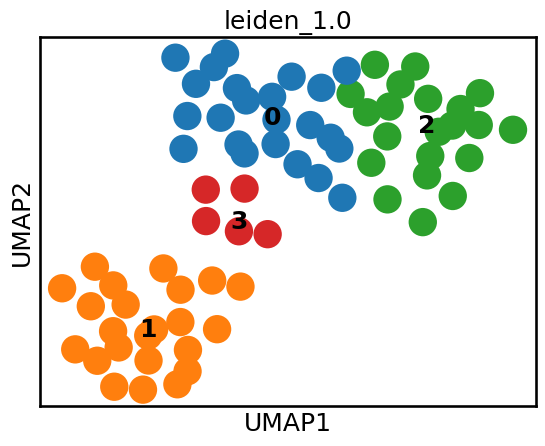

In [12]:
sc.pl.umap(adata, color=['leiden_1.0'], legend_loc='on data')

### second one

In [13]:
# adata = AnnData((2**pd.read_csv('../../GroundTruth/remisdata/scRNA/chen_rna_filtered_log2.tsv', sep='\t'))-1).T
# adata.X.max()

In [14]:
# adata.var

In [15]:
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)
# sc.tl.leiden(adata, key_added='leiden_1.0', resolution=1.0)

In [16]:
#sc.pl.umap(adata, color=['leiden_1.0'], legend_loc='on data')

### preprocessing

In [17]:
adata.var["id_in_vocab"] = [
    1 if gene in vocab else -1 for gene in adata.var.index
]
gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])

In [18]:
set(adata.var[adata.var["id_in_vocab"] < 0]) & set({'CDX2', 'FGFR2', 'HESX1', 'NANOG', 'OTX2', 'PHC1', 'POU5F1', 'REST', 'SOX2', "MYC", "KLF4"})

set()

In [19]:
adata = adata[:, adata.var["id_in_vocab"] >= 0]

In [20]:
adata.shape

(72, 17725)

In the scGPT workflow, we compare each TF perturbation condition with control
one at a time. In each run, the data is subsetted to contain one TF and control
only. In this example, we use the TF BHLHE40.


We further pre-process the subsetted data following the scGPT pipeline.


In [21]:
data_is_raw=True

In [22]:
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=3,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=False,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key="str_batch")

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


In [23]:
adata.shape

(72, 16804)

## Step 2: Retrieve scGPT's attention weights


### 2.1 Prepare model input


In [24]:
input_layer_key = "X_binned"
all_counts = (
    adata.layers[input_layer_key].A
    if issparse(adata.layers[input_layer_key])
    else adata.layers[input_layer_key]
)
genes = adata.var.index.tolist()
gene_ids = np.array(vocab(genes), dtype=int)

### 2.1 Retrieve attention weights

Note that since the flash-attn package does not output attention scores, we
manually calculate q @ k.T to extract the attention weights. Users may specify
which layer to extract the attention weights from. In the manuscript, we used
the attention weights from the last (12th) layer.


In [39]:
tokenized_all = tokenize_and_pad_batch(
        all_counts,
        gene_ids,
        max_len=len(genes) + 1,
        vocab=vocab,
        pad_token=pad_token,
        pad_value=pad_value,
        append_cls=True,  # append <cls> token at the beginning
        include_zero_gene=True,
    )

In [40]:
all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])

In [29]:
def get_attention(layer_num=11, batch_size=8):

    torch.cuda.empty_cache()
    dict_sum_condition = {}
    model.eval()
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):
        M = all_gene_ids.size(1)
        N = all_gene_ids.size(0)
        device = next(model.parameters()).device
        for i in tqdm(range(0, N, batch_size)):
            batch_size = all_gene_ids[i : i + batch_size].size(0)
            outputs = np.zeros((batch_size, M, M), dtype=np.float32)
            # Replicate the operations in model forward pass
            src_embs = model.encoder(
                torch.tensor(all_gene_ids[i : i + batch_size], dtype=torch.long).to(device)
            )
            val_embs = model.value_encoder(
                torch.tensor(all_values[i : i + batch_size], dtype=torch.float).to(device)
            )
            total_embs = src_embs + val_embs
            # total_embs = model.layer(total_embs.permute(0, 2, 1)).permute(0, 2, 1)
            # Send total_embs to attention layers for attention operations
            # Retrieve the output from second to last layer
            for layer in model.transformer_encoder.layers[:layer_num]:
                total_embs = layer(
                    total_embs,
                    src_key_padding_mask=src_key_padding_mask[i : i + batch_size].to(
                        device
                    ),
                )
            # Send total_embs to the last layer in flash-attn
            # https://github.com/HazyResearch/flash-attention/blob/1b18f1b7a133c20904c096b8b222a0916e1b3d37/flash_attn/flash_attention.py#L90
            qkv = model.transformer_encoder.layers[layer_num].self_attn.Wqkv(
                total_embs
            )
            # Retrieve q, k, and v from flast-attn wrapper
            qkv = rearrange(qkv, "b s (three h d) -> b s three h d", three=3, h=8)
            q = qkv[:, :, 0, :, :]
            k = qkv[:, :, 1, :, :]
            v = qkv[:, :, 2, :, :]
            # https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a
            # q = [batch, gene, n_heads, n_hid]
            # k = [batch, gene, n_heads, n_hid]
            # attn_scores = [batch, n_heads, gene, gene]
            attn_scores = q.permute(0, 2, 1, 3) @ k.permute(0, 2, 3, 1)
            # apply softmax to get attention weights
            attn_scores = softmax(attn_scores, dim=-1)
            if i == 0:
                sm_attn_scores = attn_scores.sum(0).detach().cpu().numpy()
            else:
                # take the sum
                sm_attn_scores += attn_scores.sum(0).detach().cpu().numpy()
    gene_vocab_idx = all_gene_ids[0].clone().detach().cpu().numpy()
    return sm_attn_scores
    # return [pd.DataFrame(data=sm_attn_scores[i], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx)) for i in range(0,8)]

In [30]:
sm_attn_scores = get_attention(11, 1)

100%|██████████| 72/72 [08:20<00:00,  6.95s/it]


In [26]:
import pickle

In [32]:
# save as pkl
#with open("./attn_scores.pkl", "wb") as f:
#    pickle.dump(sm_attn_scores, f)

In [33]:
sm_attn_scores.shape

(8, 16805, 16805)

In [28]:
# load
with open("./attn_scores.pkl", "rb") as f:
    sm_attn_scores = pickle.load(f)

EOFError: Ran out of input

### trying with softmax

In [41]:
gene_vocab_idx = all_gene_ids[0].clone().detach().cpu().numpy()

In [34]:
sm_attn_scores.shape

(8, 6586, 6586)

In [36]:
(((sm_attn_scores>2).sum(1)>1).sum(0)>1).sum()

170

In [37]:
(((sm_attn_scores>1).sum(1)>1).sum(0)>1).sum()

440

- 1000 genes have an attention score high across the 8 attention heads
- on avg 200 per attention heads
- 2000 have ok attention score across them all. meaning only 30% of the genes are really attended to

In [37]:
sm_attn_scores[:,(sm_attn_scores>1).sum(1)>1].shape

IndexError: boolean index did not match indexed array along dimension 1; dimension is 6586 but corresponding boolean dimension is 8

only a tiny fraction of the data has high attention weights

In [42]:
sm_attn_scores_h0 = pd.DataFrame(data=sm_attn_scores[0], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx))
sm_attn_scores_h0[(sm_attn_scores_h0>2).sum(0)>500].index

Index(['C20orf203', 'CALML3-AS1', 'EHMT2-AS1', 'EIF2S3B', 'EPHA1-AS1',
       'FAM157B', 'FAM3D-AS1', 'FAM95B1', 'LINC00330', 'LINC00501',
       'LINC00939', 'LINC01228', 'LINC01347', 'LINC01516', 'LINC01978',
       'LINC02023', 'LINC02280', 'LINC02447', 'LINC02474', 'NPIPA5', 'NPIPB13',
       'NPIPB2', 'PLA2G4E-AS1', 'POTEE', 'RGPD6', 'TRPV3', 'ZBTB7B'],
      dtype='object')

In [40]:
set(sm_attn_scores_h0.index) & {'CDX2', 'FGFR2', 'HESX1', 'NANOG', 'OTX2', 'PHC1', 'POU5F1', 'REST', 'SOX2', "MYC", "KLF4"}

{'CDX2',
 'FGFR2',
 'HESX1',
 'KLF4',
 'MYC',
 'NANOG',
 'OTX2',
 'PHC1',
 'POU5F1',
 'REST',
 'SOX2'}

In [43]:
set(sm_attn_scores_h0.index[(((sm_attn_scores>1).sum(1)>1).sum(0)>1)]) & {'CDX2', 'FGFR2', 'HESX1', 'NANOG', 'OTX2', 'PHC1', 'POU5F1', 'REST', 'SOX2', "MYC", "KLF4"}

set()

In [42]:
sm_attn_scores_h0[(sm_attn_scores_h0 > 1).sum(0)>1].shape

(183, 16805)

In [37]:
sm_attn_scores_h1 = pd.DataFrame(data=sm_attn_scores[1], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx))
sm_attn_scores_h1[(sm_attn_scores_h1>2).sum(0)>500].index

NameError: name 'gene_vocab_idx' is not defined

In [45]:
sm_attn_scores_h2 = pd.DataFrame(data=sm_attn_scores[2], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx))
sm_attn_scores_h2[(sm_attn_scores_h2>2).sum(0)>500].index

Index(['AKAP9', 'ATRN', 'CALM1', 'CD47', 'CPSF6', 'DCUN1D4', 'ELP1', 'ETNK1',
       'EXT2', 'FBXO21', 'GNAS', 'HECTD1', 'LNPK', 'MAP3K7', 'MSH2', 'NF2',
       'NLRP2', 'OSGEPL1', 'PEX3', 'PLD2', 'PRKRIP1', 'RARS2', 'RBM5', 'SENP5',
       'SEPHS1', 'SND1', 'TMEM209', 'TSC22D1', 'TTC13', 'UFSP1', 'UQCC1',
       'USP30', 'YRDC', 'ZNF287'],
      dtype='object')

In [46]:
sm_attn_scores_h3 = pd.DataFrame(data=sm_attn_scores[3], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx))
sm_attn_scores_h3[(sm_attn_scores_h3>2).sum(0)>500].index

Index(['AC099850.1', 'AC108676.1', 'ACADM', 'AIG1', 'BORCS7-ASMT', 'CALM1',
       'COCH', 'EFCAB10', 'FAM221B', 'GNAS', 'GSN-AS1', 'KLHL35', 'LACTB2-AS1',
       'LCTL', 'LINC00637', 'LINC01429', 'LINC01569', 'LINC02069', 'LINC02569',
       'LRRC23', 'PDZD9', 'PHACTR1', 'PITRM1-AS1', 'PP2D1', 'PRR34', 'RAB36',
       'RABGAP1L', 'RTN3', 'SMYD4', 'SOCS2-AS1', 'SPAG5-AS1', 'TDRD12',
       'TMEM17', 'TRIM68', 'TTC3', 'UCHL1', 'ZBTB20-AS4', 'ZCWPW1',
       'ZNF32-AS2', 'ZNRF3-AS1'],
      dtype='object')

In [47]:
sm_attn_scores_h4 = pd.DataFrame(data=sm_attn_scores[4], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx))
sm_attn_scores_h4[(sm_attn_scores_h4>2).sum(0)>500].index

Index(['ARHGAP19', 'AURKA', 'BRIP1', 'C21orf58', 'CCDC150', 'CCDC18', 'CCNF',
       'CDCA3', 'CENPI', 'CEP128', 'CYP4A11', 'DNAH2', 'E2F8', 'ECT2L',
       'ESPL1', 'FBXO43', 'FTHL17', 'GEN1', 'INCA1', 'KAT2B', 'KIF18B',
       'LINC00658', 'LINC01301', 'LUZP4', 'M1AP', 'MAD2L1', 'MCM7',
       'MIS18A-AS1', 'MS4A18', 'MYCBPAP', 'NEIL3', 'PAGE5', 'PELI2',
       'PRMT5-AS1', 'PSMC3IP', 'RECQL4', 'RSPH9', 'TESK2', 'TOP2A', 'UNKL',
       'WFDC6', 'ZNF257', 'ZWINT'],
      dtype='object')

In [48]:
sm_attn_scores_h5 = pd.DataFrame(data=sm_attn_scores[5], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx))
sm_attn_scores_h5[(sm_attn_scores_h5>2).sum(0)>500].index

Index(['ADAP2', 'AEN', 'ASS1', 'BRDT', 'CD86', 'CLDN2', 'CPA4', 'CSF1R',
       'CTSV', 'CX3CR1', 'CYP19A1', 'DPYS', 'ERBB3', 'FLI1', 'FMO3', 'GDA',
       'GJA1', 'GLYCTK', 'GRAMD2A', 'IRF8', 'MID1', 'MPP1', 'MS4A7', 'NCF4',
       'NFE2L3', 'NRSN1', 'PAGE1', 'PAPPA2', 'POR', 'PRAMEF11', 'PRR15', 'PTN',
       'SLC7A8', 'SOX4', 'SPARC', 'SYCP1', 'TBPL2', 'TMEM139', 'TPTEP1',
       'VGLL1'],
      dtype='object')

In [49]:
sm_attn_scores_h6 = pd.DataFrame(data=sm_attn_scores[6], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx))
sm_attn_scores_h6[(sm_attn_scores_h6>2).sum(0)>500].index

Index(['BRICD5', 'C20orf203', 'CBX2', 'DNAJC30', 'FADS6', 'FAM78A', 'FDXACB1',
       'HSD17B1', 'LZTS1', 'NAPA-AS1', 'NCKAP5L', 'P2RY11', 'PLA2G6', 'PLCXD1',
       'PM20D2', 'RINL', 'TAF6', 'TNFRSF10A', 'TTLL12'],
      dtype='object')

In [50]:
sm_attn_scores_h7 = pd.DataFrame(data=sm_attn_scores[7], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx))
sm_attn_scores_h7[(sm_attn_scores_h7>2).sum(0)>500].index

Index(['ARID3B', 'ATP6V0A2', 'BBS2', 'CEP97', 'DLG3', 'DPY19L3', 'ERVK13-1',
       'KLF8', 'MAGI2-AS3', 'MIPEP', 'NAA16', 'NADK2', 'PACS2', 'SIRT5',
       'SLC15A2', 'SLC27A1', 'TEX2', 'TMEM184B', 'TRAM2', 'UNKL', 'WWC3',
       'ZNRF3'],
      dtype='object')

'ATF3',
 'CBX8',
 'NANOG',
 'RXRA',
 'SAP30',

In [ ]:
- POU5F1 in h5
- JUN in h4
- NANOG in h3

In [80]:
sm_attn_scores_h5[(sm_attn_scores_h5>2).sum(0)>300].index

Index(['ADAP2', 'AEN', 'APOA2', 'ASS1', 'BRDT', 'CA2', 'CABYR', 'CD34', 'CD86',
       'CLDN2', 'CNBD1', 'CPA4', 'CSF1R', 'CTSV', 'CX3CR1', 'CYP19A1',
       'CYP2B6', 'CYP2E1', 'DPYS', 'ERBB3', 'FER1L6-AS2', 'FLI1', 'FMO3',
       'GBP4', 'GDA', 'GJA1', 'GLYCTK', 'GRAMD2A', 'GTSF1', 'IRF8', 'LAMA3',
       'LINC01180', 'LINC01194', 'MID1', 'MPP1', 'MS4A7', 'NCF4', 'NFE2L3',
       'NRSN1', 'PAGE1', 'PAPPA2', 'PDCL3', 'POR', 'POU5F1', 'PRAMEF11',
       'PRR15', 'PTN', 'SLC51A', 'SLC7A8', 'SOX4', 'SPARC', 'SYCP1', 'TBPL2',
       'TESPA1', 'TMEM139', 'TPTEP1', 'TRAFD1', 'VGLL1'],
      dtype='object')

In [77]:
(sm_attn_scores_h7.loc[:,[
 'CTBP2',
 'JUN',
 'KDM5A',
 'MYC',
 'POU5F1',
 'CDX2',
 'FGFR2',
 'NANOG',
 'SOX2',
 "KLF4",
 'REST',
 'SUZ12']]>2).sum(0)

CTBP2     0
JUN       0
KDM5A     0
MYC       0
POU5F1    0
CDX2      0
FGFR2     0
NANOG     0
SOX2      0
KLF4      0
REST      0
SUZ12     0
dtype: int64

In [79]:
set(sm_attn_scores_h5[sm_attn_scores_h5['POU5F1']>2]['POU5F1'].index)

{'ABHD16A',
 'ACTN4',
 'ACTR10',
 'ACTR1A',
 'ACTR3',
 'ACTR6',
 'AGPAT1',
 'AGTRAP',
 'AKIRIN1',
 'AKIRIN2',
 'ANKRD13D',
 'AP3S1',
 'APEH',
 'APH1A',
 'ARIH2',
 'ARL2BP',
 'ARL5A',
 'ARL8A',
 'ARMCX1',
 'ARMCX3',
 'ASF1A',
 'ATP1A1',
 'ATP6V0D1',
 'ATP6V1B2',
 'AZI2',
 'B4GALT3',
 'BCAS2',
 'BIRC2',
 'BLOC1S6',
 'BNIP3L',
 'C12orf76',
 'C5orf15',
 'CALCOCO2',
 'CAPZA1',
 'CAPZA2',
 'CAST',
 'CAT',
 'CCAR2',
 'CCDC28A',
 'CCNDBP1',
 'CCNG1',
 'CCS',
 'CD44',
 'CD46',
 'CD74',
 'CDK16',
 'CDK2AP1',
 'CDK5R2',
 'CDK5RAP3',
 'CDV3',
 'CEBPG',
 'CEBPZOS',
 'CERS2',
 'CHID1',
 'CLDND1',
 'CLK3',
 'CNN2',
 'CNOT7',
 'COASY',
 'COPS2',
 'COPS7A',
 'COTL1',
 'CPNE1',
 'CREB3',
 'CREG1',
 'CSNK1D',
 'CSNK1E',
 'CTDSP1',
 'CTSF',
 'CXCL16',
 'CYTH2',
 'DAP3',
 'DDIT3',
 'DDIT4',
 'DDX54',
 'DHPS',
 'DMAP1',
 'DNAJB6',
 'DPF2',
 'DRAM2',
 'DUSP1',
 'DUSP6',
 'ECSIT',
 'EIF2A',
 'EIF2S3',
 'FAM53C',
 'FBXL12',
 'FDFT1',
 'FEZ2',
 'FGFR1OP2',
 'FLII',
 'FLOT1',
 'FRAT2',
 'FUNDC2',
 'FXR1',
 'GADD

we lack many of the key TF in ESCs: [SOX2, CDX2, NANOG, OTX2] which is weird as we would expect them to be expressed in ESCs

In [ ]:
set(sm_attn_scores_h1.index) & set({'CDX2', 'FGFR2', 'HESX1', 'NANOG', 'OTX2', 'PHC1', 'POU5F1', 'REST', 'SOX2'})

{'FGFR2', 'HESX1', 'PHC1', 'POU5F1', 'REST'}

In [ ]:
sm_attn_scores_h6

<cls>           A2M     A2ML1-AS1          AAAS      AACS  \
<cls>      5.469894e-24  3.603647e-11  2.041799e-07  7.020150e-10  0.708185   
A2M        4.798223e-12  4.946420e-08  2.742793e-04  1.758731e-05  0.172523   
A2ML1-AS1  1.109466e-16  1.566302e-07  2.817782e-06  4.867422e-07  0.297205   
AAAS       1.699819e-15  5.350672e-07  1.014307e-04  6.623388e-08  0.189294   
AACS       3.880906e-14  1.359513e-08  2.125757e-05  2.749306e-05  0.972692   
...                 ...           ...           ...           ...       ...   
ZWILCH     1.252163e-16  1.036182e-05  2.422251e-06  8.783523e-08  0.835561   
ZWINT      9.594151e-18  2.974966e-06  1.135038e-05  1.574183e-07  0.649088   
ZXDC       1.541514e-17  2.670330e-08  1.817235e-06  1.763488e-08  0.669788   
ZZEF1      1.609583e-16  1.166739e-09  2.273059e-06  9.532414e-08  0.270431   
ZZZ3       4.290574e-18  1.120718e-08  1.293920e-06  1.332238e-08  0.604702   

              AADAT      AAK1         AAMDC      AAR2     AARS2  ...  \
<cls>      0.007651  0.000012  7.700687e-14  0.000047  0.000928  ...   
A2M        0.011252  0.000519  7.123806e-08  0.002022  0.029963  ...   
A2ML1-AS1  0.000087  0.000673  2.001106e-09  0.000185  0.008028  ...   
AAAS       0.000007  0.000407  1.054625e-08  0.001084  0.012341  ...   
AACS       0.000001  0.000513  1.551357e-09  0.000322  0.020745  ...   
...             ...       ...           ...       ...       ...  ...   
ZWILCH     0.002058  0.000734  8.351669e-09  0.000540  0.005259  ...   
ZWINT      0.000388  0.000330  8.378746e-09  0.000187  0.008335  ...   
ZXDC       0.096134  0.000276  1.725254e-10  0.000635  0.004819  ...   
ZZEF1      0.012077  0.000442  2.672305e-10  0.000117  0.007739  ...   
ZZZ3       0.126026  0.000200  1.553595e-10  0.000332  0.003567  ...   

                ZSCAN29       ZSCAN30        ZSCAN9        ZSWIM6  \
<cls>      1.782746e-16  1.386043e-11  2.695617e-06  8.737299e-19   
A2M        1.836345e-09  4.309542e-06  2.292635e-04  2.758255e-11   
A2ML1-AS1  1.720960e-13  1.569618e-10  1.211341e-05  8.636718e-14   
AAAS       2.457057e-13  3.045493e-11  3.902227e-06  3.686557e-16   
AACS       1.046544e-11  3.298867e-08  9.372757e-07  2.325674e-11   
...                 ...           ...           ...           ...   
ZWILCH     6.045074e-14  6.847463e-11  3.240232e-04  9.457303e-16   
ZWINT      4.691893e-15  2.637299e-12  1.382981e-05  1.796030e-18   
ZXDC       2.653458e-12  1.234087e-08  1.109618e-04  1.978908e-13   
ZZEF1      1.038560e-09  3.187503e-07  1.691384e-04  1.067575e-10   
ZZZ3       2.548001e-11  1.362864e-08  2.129842e-04  2.954149e-13   

                 ZSWIM7        ZWILCH         ZWINT      ZXDC         ZZEF1  \
<cls>      1.369459e-11  2.154669e-06  4.198771e-13  0.000532  1.311442e-23   
A2M        1.213514e-06  5.472377e-05  1.936797e-07  0.001536  1.278936e-13   
A2ML1-AS1  1.721278e-07  1.015880e-05  7.139113e-09  0.000342  2.404030e-19   
AAAS       2.531728e-06  4.185665e-06  5.649630e-07  0.000347  2.417834e-20   
AACS       5.508788e-06  1.670348e-07  2.821232e-07  0.005588  2.905312e-15   
...                 ...           ...           ...       ...           ...   
ZWILCH     1.483636e-08  2.928368e-06  3.659824e-08  0.000459  1.035163e-20   
ZWINT      6.422682e-08  3.632369e-06  3.789042e-10  0.000094  4.157239e-23   
ZXDC       5.490104e-09  8.748338e-05  3.366627e-10  0.000789  7.575397e-18   
ZZEF1      4.216480e-09  2.749562e-05  6.876666e-10  0.038932  6.725706e-16   
ZZZ3       3.031629e-09  5.700217e-05  1.216658e-10  0.009301  9.199925e-17   

                   ZZZ3  
<cls>      3.497860e-07  
A2M        3.405679e-05  
A2ML1-AS1  4.924420e-06  
AAAS       1.897555e-05  
AACS       1.401923e-04  
...                 ...  
ZWILCH     4.871220e-06  
ZWINT      7.158479e-07  
ZXDC       3.557317e-06  
ZZEF1      9.574518e-05  
ZZZ3       7.232911e-07  

[6586 rows x 6586 columns]

0       6350
1         30
2         20
5         10
3          7
        ... 
6008       1
1875       1
33         1
6519       1
38         1
Length: 132, dtype: int64


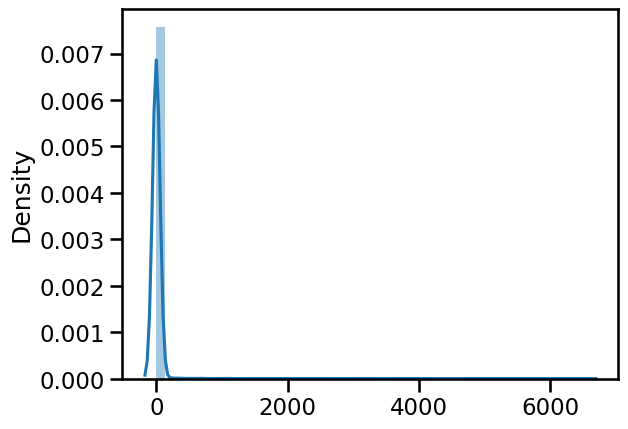

In [ ]:
#(sm_attn_scores_h0>2).sum()
# plot distribution
import seaborn as sns

sns.distplot((sm_attn_scores_h0>2).sum())

print((sm_attn_scores_h0>2).sum().value_counts())

In [ ]:
from bertviz import head_view

In [ ]:
SIZE = 70
LOC = 1000
head_view([torch.FloatTensor([sm_attn_scores[:,LOC:LOC+SIZE,LOC:LOC+SIZE]])], sm_attn_scores_h0.index.tolist()[LOC:LOC+SIZE])

<IPython.core.display.Javascript object>

### how is attention changing across layers? 

In [60]:
attention = get_attention(1, 1)

  0%|          | 0/72 [00:00<?, ?it/s]

100%|██████████| 72/72 [08:29<00:00,  7.08s/it]


In [62]:
attention.shape

(8, 16805, 16805)

In [61]:
# save as pkl
with open("./attn_scores.pkl", "wb") as f:
    pickle.dump(sm_attn_scores, f)

In [67]:
((attention[7]>2).sum(0)>500).sum()

29

In [80]:
#sample some elements from attention
import numpy as np

random_indices = np.random.randint(low=0, high=attention.shape[1], size=SIZE)
sampled_attention = attention[:, random_indices, :][:,:,random_indices]


In [84]:
head_view([torch.FloatTensor([sampled_attention])], sm_attn_scores_h0.index[random_indices].tolist())

<IPython.core.display.Javascript object>

In [ ]:
SIZE = 70
LOC = 2000
head_view([torch.FloatTensor([attention[:,LOC:LOC+SIZE,LOC:LOC+SIZE]])], sm_attn_scores_h0.index.tolist()[LOC:LOC+SIZE])

In [69]:
SIZE = 70
LOC = 2000
head_view([torch.FloatTensor([attention[:,LOC:LOC+SIZE,LOC:LOC+SIZE]])], sm_attn_scores_h0.index.tolist()[LOC:LOC+SIZE])

<IPython.core.display.Javascript object>

In [ ]:
val = (attention[2]>2).sum(0)
val[np.argsort(val.tolist())][-20:]

SFXN2       2116
CCDC77      2155
MSH2        2167
NUP85       2306
GMNN        2368
CHEK1       2641
RFC2        2770
ZNF789      2819
ZNF714      2939
AGPS        3026
CNOT10      3078
UTP14C      3105
GLMN        3123
TNPO3       3199
RNF4        3698
NIF3L1      3805
E2F1        4055
CDK5RAP1    4458
SLC25A17    4525
CSTF1       5525
dtype: int64

In [ ]:
import gseapy as gp
from gseapy.plot import dotplot

In [ ]:
pre_res = gp.prerank(rnk=val[np.argsort(val.tolist())[::-1]], # or rnk = rnk,
                    gene_sets="KEGG_2016",
                    #"ENCODE_TF_ChIP-seq_2014",
                    #'GO_Molecular_Function_2015', #
                    min_size=5,
                    max_size=1000,
                    permutation_num=1000, # reduce number to speed up testing
                    outdir=None, # don't write to disk
                    seed=6,
                    verbose=True, # see what's going on behind the scenes
            )

2023-10-27 16:55:43,149 [WARNING] Duplicated values found in preranked stats: 95.98% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-10-27 16:55:43,150 [INFO] Parsing data files for GSEA.............................


2023-10-27 16:55:43,832 [INFO] Downloading and generating Enrichr library gene sets......
2023-10-27 16:55:50,271 [INFO] 0023 gene_sets have been filtered out when max_size=1000 and min_size=5
2023-10-27 16:55:50,273 [INFO] 0270 gene_sets used for further statistical testing.....
2023-10-27 16:55:50,275 [INFO] Start to run GSEA...Might take a while..................
2023-10-27 16:55:53,955 [INFO] Congratulations. GSEApy runs successfully................



In [ ]:
# TF chip
pre_res.res2d[pre_res.res2d['FDR q-val']<0.05].sort_values(by=["NES"], ascending=False)

Empty DataFrame
Columns: [Name, Term, ES, NES, NOM p-val, FDR q-val, FWER p-val, Tag %, Gene %, Lead_genes]
Index: []

In [ ]:
# GO MF
pre_res.res2d[pre_res.res2d['FDR q-val']<0.05].sort_values(by=["NES"], ascending=False)

Name                                               Term        ES  \
138  prerank             ligase regulator activity (GO:0055103)  0.998936   
139  prerank  nucleoside transmembrane transporter activity ...  0.999848   
140  prerank  nucleobase-containing compound transmembrane t...  0.999848   
141  prerank      4 iron, 4 sulfur cluster binding (GO:0051539)  0.998127   
142  prerank  nucleotide transmembrane transporter activity ...  0.999848   
143  prerank         cofactor transporter activity (GO:0051184)  0.997643   
144  prerank                          SUMO binding (GO:0032183)   0.99924   
145  prerank  carbohydrate derivative transporter activity (...  0.998965   
146  prerank  phosphate transmembrane transporter activity (...  0.998965   
147  prerank  organophosphate ester transmembrane transporte...  0.998965   
148  prerank   flavin adenine dinucleotide binding (GO:0050660)  0.996826   
149  prerank  protein serine/threonine/tyrosine kinase activ...  0.996464   
150  prerank     MAP kinase kinase kinase activity (GO:0004709)   0.99696   
151  prerank                           FAD binding (GO:0071949)   0.99848   
152  prerank              scaffold protein binding (GO:0097110)  0.996956   
153  prerank            MAP kinase kinase activity (GO:0004708)  0.996471   
155  prerank  receptor signaling protein serine/threonine ki...  0.995003   
156  prerank  L-amino acid transmembrane transporter activit...  0.996348   
157  prerank        3'-5'-exoribonuclease activity (GO:0000175)  0.993609   
158  prerank     small conjugating protein binding (GO:0032182)  0.992349   

          NES NOM p-val FDR q-val FWER p-val Tag % Gene %  Lead_genes  
138  1.053438  0.002488  0.936668      0.485   1/5  0.12%        GLMN  
139  1.052925  0.007335   0.82405      0.681   1/5  0.03%    SLC25A17  
140  1.052904  0.002825   0.55962      0.686  1/12  0.03%    SLC25A17  
141  1.052407  0.004158  0.658347      0.822  1/29  0.05%    CDK5RAP1  
142  1.052047  0.004202  0.685435      0.897   1/6  0.03%    SLC25A17  
143  1.052018  0.021645  0.583433      0.898   1/6  0.03%    SLC25A17  
144  1.051942  0.016043  0.527585      0.905   1/8  0.09%        RNF4  
145    1.0518  0.010582    0.5079      0.919  1/13  0.03%    SLC25A17  
146  1.051155  0.011111  0.658292      0.979   1/9  0.03%    SLC25A17  
147  1.050781  0.011236  0.710241      0.988   1/7  0.03%    SLC25A17  
148  1.050513  0.013001  0.727307      0.993  1/24  0.17%        AGPS  
149  1.050481  0.017621  0.674884      0.994  1/23  0.32%      MAP3K7  
150  1.050457  0.025743  0.628618      0.994   1/7  0.32%      MAP3K7  
151  1.050455  0.015837  0.584709      0.994   1/5  0.17%        AGPS  
152  1.050321  0.025157  0.574371      0.997  1/16  0.32%      MAP3K7  
153  1.049421  0.036424  0.731214      0.999   1/8  0.32%      MAP3K7  
155  1.047496  0.036158       1.0        1.0  1/21  0.32%      MAP3K7  
156  1.047426  0.024096  0.990771        1.0  1/14  0.38%      SLC7A3  
157  1.047344   0.04436  0.956463        1.0  1/14  0.65%      EXOSC9  
158  1.047036  0.016032   0.96601        1.0  2/51  0.79%  RNF4;UIMC1

In [ ]:
# KEGG 2016
pre_res.res2d[(pre_res.res2d['FDR q-val']<0.05) & (pre_res.res2d['NES']>1)].sort_values(by=["NES"], ascending=False)

Empty DataFrame
Columns: [Name, Term, ES, NES, NOM p-val, FDR q-val, FWER p-val, Tag %, Gene %, Lead_genes]
Index: []

In [ ]:
# TF lof
pre_res.res2d[(pre_res.res2d['FDR q-val']<0.05) & (pre_res.res2d['NES']>1)].sort_values(by=["NES"], ascending=False)

Name                                               Term        ES  \
0   prerank  cdkn1b 00000000 mouse embryonic fibroblast mef...  0.996279   
1   prerank     stat3 18500982 mesc gof mouse gpl83 gds3446 up  0.995735   
2   prerank      sox4 16636670 acc3 lof human gpl96 gds2193 up  0.991209   
3   prerank  tcf3 20154672 cd4pos cd8pos thymocytes thymus ...  0.992833   
5   prerank     esr1 21713035 mcf7 lof human gpl570 gds4061 up   0.98508   
6   prerank  sp1 22099172 dental follicle cell gof human gp...  0.987608   
8   prerank  e2f1 21245101 mmtv-myc lof mouse gpl8321 gds40...  0.988803   
10  prerank  stat3 18070348 alveolar type 2 epithelial lof ...  0.982366   
19  prerank           rara 21299862 mcf7 lof human  gds4065 up  0.965944   
30  prerank   cdkn1b 18180298 3t3 lof mouse gpl1261 gse9161 up  0.959718   
36  prerank  foxa1 21151129 mcfdash7 lof human gpl10558 gse...  0.955484   
39  prerank  zfx 17448993 embryonic stem cell lof mouse gpl...   0.95389   

         NES NOM p-val FDR q-val FWER p-val   Tag % Gene %  \
0   1.052204     0.003  0.349548      0.286    2/86  0.26%   
1     1.0491  0.018868  0.608713      0.702    1/21  0.44%   
2   1.049047  0.001001  0.409803      0.707    1/86  0.02%   
3   1.045921  0.037433   0.57975      0.899    1/28  0.73%   
5   1.043882     0.002  0.531146      0.955   1/141  0.17%   
6   1.042316  0.040323  0.559705      0.976    1/47  0.49%   
8   1.040965  0.042596  0.516998       0.99    2/40  0.46%   
10   1.04006     0.006  0.468213      0.995   3/103  0.84%   
19  1.023654      0.03       1.0        1.0   4/153  2.14%   
30  1.017577     0.047       1.0        1.0  31/240  3.74%   
36  1.015357     0.004       1.0        1.0  87/633  4.97%   
39  1.013642     0.015       1.0        1.0  40/513  3.64%   

                                           Lead_genes  
0                                          E2F1;NUP85  
1                                               CDC45  
2                                               CSTF1  
3                                              PRRC2C  
5                                                AGPS  
6                                               KDM2A  
8                                          E2F1;MGME1  
10                                  NUP50;KDM2A;RBM25  
19                            KPNB1;BUB1;ZZEF1;UBE2D2  
30  CDK5RAP1;CNOT10;RFC2;CHEK1;NUP85;CENPQ;CDT1;MC...  
36  CSTF1;CDK5RAP1;CHEK1;GMNN;NUP85;CDC7;NUP50;FOX...  
39  E2F1;RNF4;NUP85;MSH2;SFXN2;CDC7;SLC7A3;CDT1;LI...

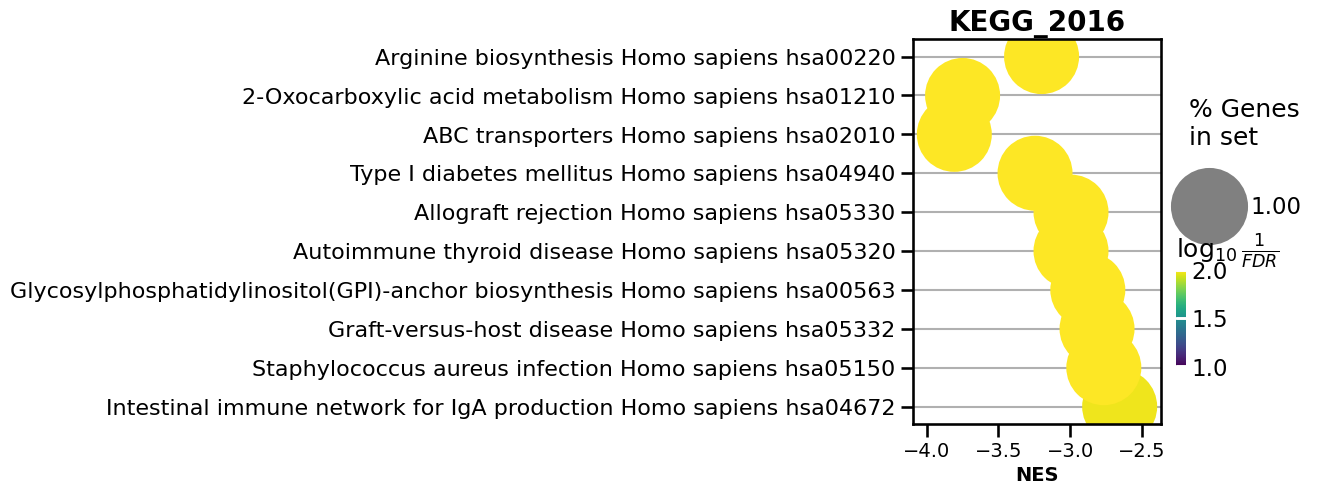

In [ ]:
ax = dotplot(pre_res.res2d,
            column="FDR q-val",
            title='KEGG_2016',
            cmap=plt.cm.viridis,
            size=6, # adjust dot size
            figsize=(4,5), cutoff=0.25, show_ring=False)

In [ ]:
# find if list

In [ ]:
((attention[2]>2).sum(1)>1).sum()

6586

In [ ]:
attention[0]

<cls>           A2M  A2ML1-AS1          AAAS      AACS  \
<cls>      6.251516e-24  2.156847e-11   0.000008  3.500126e-12  0.000148   
A2M        3.440236e-14  1.484948e-06   0.001892  9.030621e-06  0.005145   
A2ML1-AS1  4.768287e-17  2.913375e-08   0.000038  2.863268e-07  0.001429   
AAAS       1.069487e-16  4.162837e-08   0.000209  1.112423e-07  0.001413   
AACS       1.247571e-18  2.531978e-10   0.000126  1.293267e-07  0.001140   
...                 ...           ...        ...           ...       ...   
ZWILCH     1.269345e-18  1.993809e-09   0.000032  2.841005e-08  0.000987   
ZWINT      7.894099e-19  1.670468e-08   0.000041  2.364396e-07  0.001227   
ZXDC       1.710701e-18  4.990012e-10   0.001701  1.055009e-07  0.001109   
ZZEF1      3.384000e-18  2.862850e-10   0.003193  2.107652e-07  0.000595   
ZZZ3       1.014040e-17  1.249514e-09   0.003709  2.678965e-07  0.000955   

                  AADAT          AAK1         AAMDC      AAR2     AARS2  ...  \
<cls>      1.546307e-11  8.609339e-08  4.318440e-18  0.000002  0.456652  ...   
A2M        4.383845e-11  9.516114e-05  1.849078e-10  0.000006  0.017956  ...   
A2ML1-AS1  2.757728e-11  4.697744e-06  6.171960e-14  0.000034  0.209117  ...   
AAAS       1.777899e-11  1.340159e-05  1.030960e-12  0.000115  0.241859  ...   
AACS       1.962076e-14  1.890720e-06  7.446058e-15  0.000015  0.143844  ...   
...                 ...           ...           ...       ...       ...  ...   
ZWILCH     4.750262e-13  2.111978e-07  4.758491e-15  0.000014  0.395679  ...   
ZWINT      1.463420e-12  1.691168e-06  6.594557e-14  0.000009  0.174474  ...   
ZXDC       4.234302e-12  9.750861e-07  1.893328e-14  0.000369  0.767452  ...   
ZZEF1      3.942846e-13  1.696152e-07  1.672181e-14  0.000264  0.648734  ...   
ZZZ3       3.559322e-11  1.106846e-06  6.001348e-14  0.001185  0.807902  ...   

                ZSCAN29       ZSCAN30        ZSCAN9        ZSWIM6  \
<cls>      2.046740e-08  5.711512e-11  9.132620e-11  1.226737e-12   
A2M        9.564861e-16  4.682942e-12  3.426701e-10  2.934691e-11   
A2ML1-AS1  1.213983e-16  1.227787e-14  2.211394e-10  3.133618e-14   
AAAS       4.266304e-17  5.167947e-16  4.310201e-10  1.205478e-15   
AACS       2.523581e-18  1.382052e-17  2.472169e-13  2.976579e-17   
...                 ...           ...           ...           ...   
ZWILCH     2.427769e-17  8.440562e-17  4.847229e-10  2.871202e-16   
ZWINT      9.163344e-19  2.243784e-17  3.504779e-10  1.251750e-16   
ZXDC       1.327985e-14  5.841173e-14  3.118452e-11  1.953423e-16   
ZZEF1      3.083386e-15  9.580691e-16  5.101426e-12  3.062683e-17   
ZZZ3       1.907360e-12  2.211986e-13  8.405120e-10  7.444304e-15   

                 ZSWIM7        ZWILCH         ZWINT          ZXDC  \
<cls>      1.597433e-11  7.639338e-15  5.012485e-19  2.322854e-04   
A2M        1.169924e-07  1.822725e-11  2.556020e-09  2.176811e-07   
A2ML1-AS1  6.837196e-09  2.037047e-12  4.726478e-12  6.630238e-08   
AAAS       4.797265e-08  8.312397e-12  4.821052e-11  4.802378e-08   
AACS       2.967777e-08  7.619383e-14  1.012986e-12  1.499575e-08   
...                 ...           ...           ...           ...   
ZWILCH     7.775935e-10  7.882717e-12  1.277553e-13  1.155404e-08   
ZWINT      1.092717e-09  1.873897e-11  9.251786e-13  3.322776e-09   
ZXDC       1.021516e-07  6.626527e-12  2.153733e-13  1.433432e-06   
ZZEF1      1.165773e-07  1.633033e-12  3.831011e-13  2.821438e-07   
ZZZ3       2.583338e-07  3.744728e-11  1.029709e-12  4.245805e-06   

                  ZZEF1          ZZZ3  
<cls>      5.474073e-19  2.530788e-06  
A2M        1.387576e-16  1.072789e-05  
A2ML1-AS1  7.848742e-20  1.319954e-06  
AAAS       1.097751e-20  1.707656e-06  
AACS       2.665659e-20  4.801349e-07  
...                 ...           ...  
ZWILCH     2.608143e-21  9.939154e-07  
ZWINT      2.266129e-24  4.457777e-07  
ZXDC       2.661599e-19  2.721115e-07  
ZZEF1      6.234389e-18  2.808902e-07  
ZZZ3       7.779999e-17  1.384560e-06  

[6586

it almost seem to stay quite similar to previous layers

In [48]:
sm_attn_scores[:,:20,:20].shape

(8, 20, 20)

#

## how is attention for predicting cell type? (is it focusing on marker genes?)

## trying sum of profiles

### is the attention changing a lot when  giving similar profiles?

### 2.2 Average rank-normed attention weights by condition

In the previous step, we retrieve the attention weights for all cells and keep
the running sum by condition (i.e., control, perturbed). We further calculate
the mean here by dividing the number of cells per condition to obtain a gene \*
gene attention matrix for each condition.


In [ ]:
import pickle

In [ ]:
# Save the dict_sum_condition dictionary into a pickle file
with open("dict_sum_condition.pkl", "wb") as f:
    pickle.dump(dict_sum_condition, f)

In [ ]:
with open("dict_sum_condition.pkl", "rb") as f:
    dict_sum_condition = pickle.load(f)

In [ ]:
dict_sum_condition["ctrl"][:, 0].min()

5702.0806

In [ ]:
dict_sum_condition

{'ctrl': array([[13933.864 , 14750.036 ,  7468.2954, ..., 21075.678 , 15333.064 ,
         16293.599 ],
        [10553.35  , 12885.937 ,  8244.175 , ..., 12384.878 , 14053.346 ,
         10432.787 ],
        [12433.894 ,  8533.326 , 15626.939 , ...,  9253.183 ,  6305.4907,
         10466.165 ],
        ...,
        [11588.803 , 16553.75  , 11178.08  , ..., 18365.686 , 15135.463 ,
         13061.    ],
        [11135.912 , 18614.648 ,  9089.965 , ..., 15606.838 , 21313.943 ,
         15026.249 ],
        [12904.683 , 13994.017 , 10414.641 , ..., 16110.174 , 15675.613 ,
         15082.077 ]], dtype=float32),
 'BHLHE40+ctrl': array([[300.7011 , 294.17953, 155.30495, ..., 423.96136, 339.4864 ,
         319.47537],
        [219.44547, 259.5443 , 182.31548, ..., 218.70398, 255.34238,
         155.50034],
        [223.41988, 134.66891, 332.64105, ..., 201.34746, 137.39313,
         240.91937],
        ...,
        [240.07225, 360.40375, 259.83072, ..., 387.48706, 325.08456,
         270.49344

<Axes: >

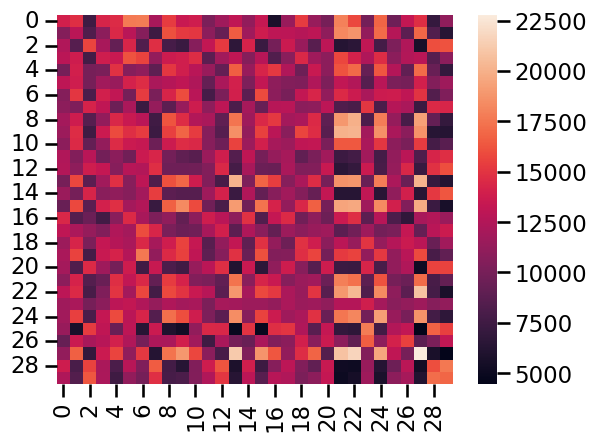

In [ ]:
import seaborn as sns

sns.heatmap(dict_sum_condition["ctrl"][:30, :30])

In [ ]:
groups = adata.obs.groupby("condition").groups

In [ ]:
dict_sum_condition_mean = dict_sum_condition.copy()
for i in groups.keys():
    dict_sum_condition_mean[i] = dict_sum_condition_mean[i] / len(groups[i])
gene_vocab_idx = all_gene_ids[0].clone().detach().cpu().numpy()

In [ ]:
dict_sum_condition_mean

{'ctrl': array([[0.5742845 , 0.60792303, 0.30780593, ..., 0.86863446, 0.6319525 ,
         0.671541  ],
        [0.4349565 , 0.53109413, 0.33978382, ..., 0.510443  , 0.5792089 ,
         0.42998752],
        [0.51246315, 0.3517012 , 0.6440646 , ..., 0.3813701 , 0.25988093,
         0.4313632 ],
        ...,
        [0.47763273, 0.68226314, 0.46070477, ..., 0.7569421 , 0.6238084 ,
         0.53830934],
        [0.45896682, 0.7672031 , 0.37464306, ..., 0.6432361 , 0.87845457,
         0.61930716],
        [0.5318667 , 0.57676363, 0.4292396 , ..., 0.66398114, 0.6460707 ,
         0.6216081 ]], dtype=float32),
 'BHLHE40+ctrl': array([[0.5966292 , 0.5836896 , 0.30814475, ..., 0.8411932 , 0.6735841 ,
         0.6338797 ],
        [0.43540767, 0.5149689 , 0.36173704, ..., 0.43393648, 0.5066317 ,
         0.30853242],
        [0.4432934 , 0.26720023, 0.6600021 , ..., 0.3994989 , 0.27260542,
         0.47801462],
        ...,
        [0.47633383, 0.7150868 , 0.51553714, ..., 0.7688235 , 0.64500

In [ ]:
dict_sum_condition_mean

{'ctrl': array([[0.7667165 , 0.5071312 , 0.363181  , ..., 0.6558552 , 0.6433118 ,
         0.5029277 ],
        [0.35063276, 0.90670127, 0.32875505, ..., 0.67563516, 0.4646933 ,
         0.4744476 ],
        [0.5349599 , 0.30492574, 0.63999563, ..., 0.37222496, 0.45482123,
         0.4780819 ],
        ...,
        [0.5522125 , 0.72981244, 0.347227  , ..., 0.7278823 , 0.5751889 ,
         0.48467204],
        [0.5728605 , 0.54362035, 0.49283794, ..., 0.5536558 , 0.71726304,
         0.59353757],
        [0.646479  , 0.52209556, 0.410678  , ..., 0.5902157 , 0.6444179 ,
         0.54989314]], dtype=float32),
 'BHLHE40+ctrl': array([[0.6798215 , 0.43131036, 0.39218244, ..., 0.67530143, 0.6967861 ,
         0.5009627 ],
        [0.28934428, 0.809951  , 0.30970335, ..., 0.61639196, 0.26737106,
         0.2312922 ],
        [0.5355754 , 0.28648922, 0.6779555 , ..., 0.3633715 , 0.51926744,
         0.59302956],
        ...,
        [0.5082808 , 0.69850725, 0.34680215, ..., 0.75059116, 0.61094

In [ ]:
        # Rank normalization by row
        attn_scores = attn_scores.reshape((-1, M))
        order = torch.argsort(attn_scores, dim=1)
        rank = torch.argsort(order, dim=1)
        attn_scores = rank.reshape((-1, 8, M, M)) / M
        # Rank normalization by column
        attn_scores = attn_scores.permute(0, 1, 3, 2).reshape((-1, M))
        order = torch.argsort(attn_scores, dim=1)
        rank = torch.argsort(order, dim=1)
        attn_scores = (rank.reshape((-1, 8, M, M)) / M).permute(0, 1, 3, 2)
        # Average 8 attention heads
        attn_scores = attn_scores.mean(1)

        outputs = attn_scores.detach().cpu().numpy()

        for index in range(batch_size):
            # Keep track of sum per condition
            c = condition_ids[i : i + batch_size][index]
            if c not in dict_sum_condition:
                dict_sum_condition[c] = np.zeros((M, M), dtype=np.float32)
            else:
                dict_sum_condition[c] += outputs[index, :, :]

## Step 3: Perform most influenced gene selection


In the manuscript, we proposed 3 settings for the most influenced gene
selection, namely _Control_, _Perturb_, and _Difference_. In this example, we
focus on the _Difference_ setting to explore how the gene-gene network changes
after perturbation compared to control.


In [ ]:
def get_topk_most_influenced_genes(topk, setting):
    attn_top_gene_dict = {}
    attn_top_scores_dict = {}
    for i in groups.keys():
        if i != "ctrl":
            knockout_gene = i.split("+")[0]
            knockout_gene_idx = np.where(gene_vocab_idx == vocab([knockout_gene])[0])[
                0
            ][0]
            control = dict_sum_condition_mean["ctrl"][:, knockout_gene_idx]
            exp = dict_sum_condition_mean[i][:, knockout_gene_idx]
            # Chnage this line to exp, control, exp-control for three different settings
            if setting == "difference":
                a = exp - control
            elif setting == "control":
                a = control
            elif setting == "experiment":
                a = exp
            diff_idx = np.argpartition(a, -topk)[-topk:]
            scores = (a)[diff_idx]
            attn_top_genes = vocab.lookup_tokens(gene_vocab_idx[diff_idx]) + [TF_name]
            attn_top_gene_dict[i] = list(attn_top_genes)
            attn_top_scores_dict[i] = list(scores)
    return attn_top_gene_dict, attn_top_scores_dict

In [ ]:
gene_vocab_idx = all_gene_ids[0].clone().detach().cpu().numpy()

In [ ]:
# Specify top k number of genes to be selected, and the selection setting
# Here calculate top 20 most influenced genes for CHIP-Atlas validation
topk = 20
setting = "difference"  # "control", "perturbed"
assert setting in ["difference", "control", "perturbed"]
attn_top_gene_dict_20, attn_top_scores_dict_20 = get_topk_most_influenced_genes(
    topk, setting
)
print(attn_top_scores_dict_20[TF_name + "+ctrl"])
print(attn_top_gene_dict_20[TF_name + "+ctrl"])

[0.17974377, 0.18082798, 0.18216205, 0.18462348, 0.19178969, 0.19324607, 0.19461662, 0.1971811, 0.1953389, 0.19469512, 0.19753253, 0.19573992, 0.19778228, 0.20109445, 0.21695876, 0.22958243, 0.20796436, 0.20723146, 0.20903969, 0.20859265]
['MYL4', 'PTTG1', 'SRRM2', 'SSR2', 'RTN4', 'CCDC85B', 'FUS', 'GYPA', 'PARP1', 'DBI', 'PSMD4', 'DNAJA1', 'EXOSC8', 'SFPQ', 'HNRNPD', 'HSPA8', 'TMBIM6', 'SH3BGRL3', 'UQCRB', 'GYPB', 'BHLHE40']


<Figure size 1800x1800 with 0 Axes>

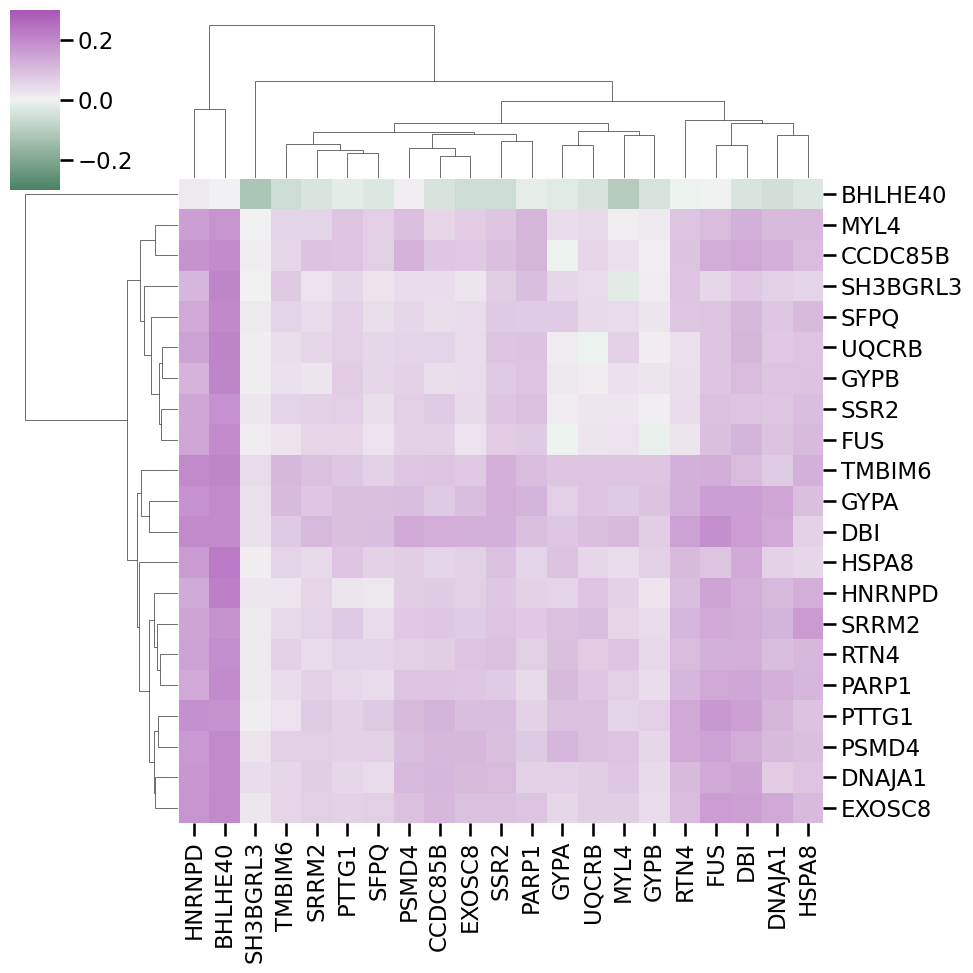

In [ ]:
if setting == "difference":
    for i in attn_top_gene_dict_20.keys():
        example_genes = attn_top_gene_dict_20[i]
        gene_idx = [
            np.where(gene_vocab_idx == vocab([g])[0])[0][0] for g in example_genes
        ]
        scores = (
            dict_sum_condition_mean[i][gene_idx, :][:, gene_idx]
            - dict_sum_condition_mean["ctrl"][gene_idx, :][:, gene_idx]
        )
        df_scores = pd.DataFrame(
            data=scores, columns=example_genes, index=example_genes
        )
        plt.figure(figsize=(6, 6), dpi=300)
        ax = sns.clustermap(
            df_scores,
            annot=False,
            cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True),
            fmt=".2f",
            vmin=-0.3,
            vmax=0.3,
        )
        plt.show()
        plt.close()

<Figure size 1800x1800 with 0 Axes>

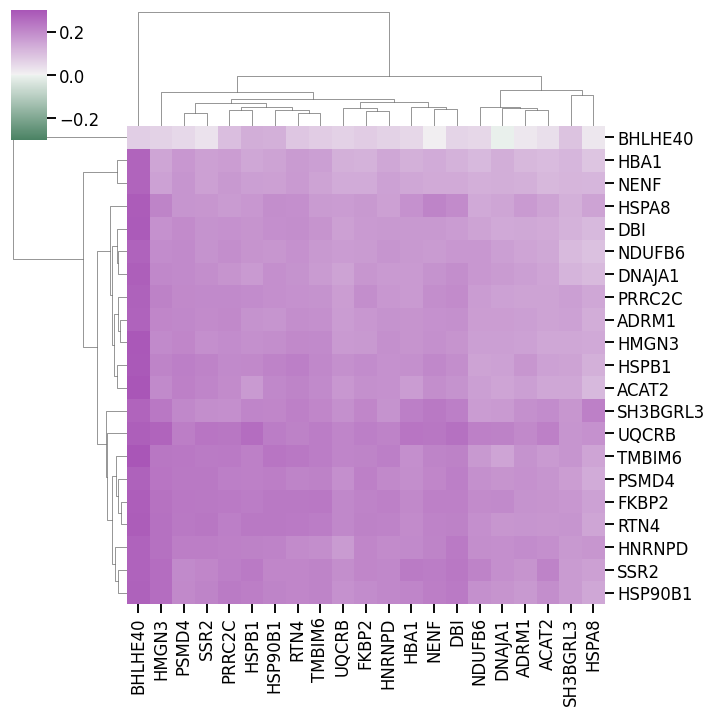

In [ ]:
if setting == "difference":
    for i in attn_top_gene_dict_20.keys():
        example_genes = attn_top_gene_dict_20[i]
        gene_idx = [
            np.where(gene_vocab_idx == vocab([g])[0])[0][0] for g in example_genes
        ]
        scores = (
            dict_sum_condition_mean[i][gene_idx, :][:, gene_idx]
            - dict_sum_condition_mean["ctrl"][gene_idx, :][:, gene_idx]
        )
        df_scores = pd.DataFrame(
            data=scores, columns=example_genes, index=example_genes
        )
        plt.figure(figsize=(6, 6), dpi=300)
        ax = sns.clustermap(
            df_scores,
            annot=False,
            cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True),
            fmt=".2f",
            vmin=-0.3,
            vmax=0.3,
        )
        plt.show()
        plt.close()

In [ ]:
# Specify top k number of genes to be selected, and the selection setting
# # Here calculate top 100 most influenced genes for pathway validation
topk = 100
setting = "difference"  # "control", "perturbed"
assert setting in ["difference", "control", "perturbed"]
attn_top_gene_dict_100, attn_top_scores_dict_100 = get_topk_most_influenced_genes(
    topk, setting
)
print(attn_top_scores_dict_100[TF_name + "+ctrl"])
print(attn_top_gene_dict_100[TF_name + "+ctrl"])

[0.0752303, 0.20859265, 0.16295224, 0.1971811, 0.11316484, 0.18462348, 0.09724718, 0.158782, 0.09412712, 0.16063309, 0.22958243, 0.17112052, 0.08037984, 0.14169514, 0.17872679, 0.090473026, 0.19324607, 0.14448231, 0.09751749, 0.0880225, 0.1201272, 0.17594087, 0.13083702, 0.106511205, 0.17096329, 0.080174506, 0.07891601, 0.20109445, 0.07867223, 0.07772222, 0.12440163, 0.17974377, 0.15514088, 0.14062035, 0.19178969, 0.13302839, 0.20723146, 0.20796436, 0.07658398, 0.07616922, 0.19778228, 0.1318911, 0.11101669, 0.08272201, 0.15474302, 0.08708018, 0.12751365, 0.12720191, 0.08016437, 0.076271415, 0.14067346, 0.1760832, 0.09925455, 0.07620722, 0.17684132, 0.19573992, 0.1570139, 0.15322667, 0.084185004, 0.087951064, 0.080433846, 0.12674385, 0.08444178, 0.08111143, 0.092929244, 0.111475885, 0.21695876, 0.19753253, 0.19461662, 0.10788423, 0.17590642, 0.096800864, 0.102776945, 0.10742286, 0.1235905, 0.10832739, 0.09279007, 0.16145891, 0.17972463, 0.08507359, 0.15073979, 0.19469512, 0.20903969, 0.

In [ ]:
# Specify top k number of genes to be selected, and the selection setting
# # Here calculate top 100 most influenced genes for pathway validation
topk = 100
setting = "difference"  # "control", "perturbed"
assert setting in ["difference", "control", "perturbed"]
attn_top_gene_dict_100, attn_top_scores_dict_100 = get_topk_most_influenced_genes(
    topk, setting
)
print(attn_top_scores_dict_100[TF_name + "+ctrl"])
print(attn_top_gene_dict_100[TF_name + "+ctrl"])

[0.13435426, 0.13445804, 0.13521338, 0.13658851, 0.13494265, 0.1378941, 0.25253183, 0.27598792, 0.27320516, 0.19422996, 0.1749267, 0.14947963, 0.28356528, 0.19787788, 0.21807176, 0.27211004, 0.19592029, 0.192339, 0.26201934, 0.27022785, 0.18904561, 0.2630661, 0.17665666, 0.25517708, 0.1592493, 0.28411555, 0.15643954, 0.17658818, 0.28957933, 0.23216242, 0.27515042, 0.17963398, 0.17776287, 0.21403193, 0.1494323, 0.26097095, 0.2147252, 0.2868172, 0.1864397, 0.19282275, 0.17112768, 0.18815774, 0.19837373, 0.14006501, 0.15750575, 0.22382861, 0.2719887, 0.25040454, 0.25988054, 0.26159328, 0.14806324, 0.20562506, 0.26052994, 0.20960271, 0.17409635, 0.22525501, 0.26490605, 0.20550716, 0.15476418, 0.14542323, 0.30242187, 0.16769892, 0.1891504, 0.16443193, 0.2682315, 0.25884175, 0.25024498, 0.26073533, 0.15007758, 0.27020293, 0.27914363, 0.24032599, 0.16723317, 0.18915558, 0.27392942, 0.15589827, 0.1956358, 0.15076661, 0.14257717, 0.2255286, 0.18222451, 0.2942825, 0.18665028, 0.29776084, 0.29275

## Step 4: Validate most influenced genes


### Step 4.1: Validate against CHIP-Atlas


First load the tsv file from CHIP-Atlas containing targets of BHLHE40. The tsv
file for BHLHE40 can be downloaded via this
[link](https://drive.google.com/drive/folders/1nc1LywRHlzt4Z17McfXiqBWgoGbRNyc0).
This tsv file was originally retrieved from the
[CHIP-Atlas](https://chip-atlas.org/target_genes) website.


In [ ]:
ls ../../GroundTruth/

hESC_Chen_Genes.tsv    hESC_Liu_TFs.tsv       mESC_Semrau_Genes.tsv
hESC_Chen_TFs.tsv      mESC_Duren_Genes.tsv   mESC_Semrau_TFs.tsv
hESC_ground_truth.tsv  mESC_Duren_TFs.tsv     scRNA/
hESC_Liu_Genes.tsv     mESC_ground_truth.tsv


In [ ]:
df = pd.read_csv("../BHLHE40.10.tsv", delimiter="\t")

Examine the overalp between the selected genes (top 20) and known target genes
from the database.


In [ ]:
df

Target_genes  BHLHE40|Average  SRX2424487|293  SRX2424488|293  \
0           CLUAP1      1414.708333             844             509   
1         C16orf90      1414.708333             844             509   
2           CCDC86      1354.458333             444             201   
3             SCAP      1327.750000             595             233   
4            SNRPE      1308.625000             373             171   
...            ...              ...             ...             ...   
15800      C3orf49         2.875000               0               0   
15801       PRSS35         2.833333               0               0   
15802      FAM71E2         2.625000               0               0   
15803       COX6B2         2.625000               0               0   
15804        RTL8C         2.500000               0               0   

       SRX150519|A549  SRX150509|GM12878  SRX3322985|GM12878  \
0                1872               2298                3403   
1                1872               2298                3403   
2                1644               2380                3504   
3                1714               2338                3210   
4                1578               2476                3674   
...               ...                ...                 ...   
15800               0                  0                   0   
15801               0                  0                   0   
15802               0                  0                   0   
15803               0                  0                   0   
15804               0                  0                   0   

       SRX3322986|GM12878  SRX6888831|HeLa  SRX6888832|HeLa  ...  \
0                    3625              949              622  ...   
1                    3625              949              622  ...   
2                    3539              704              309  ...   
3                    3449             1522              817  ...   
4                    3623              505              310  ...   
...                   ...              ...              ...  ...   
15800                   0                0                0  ...   
15801                   0                0                0  ...   
15802                   0                0                0  ...   
15803                   0                0                0  ...   
15804                   0                0                0  ...   

       SRX15783136|Jurkat  SRX15783137|Jurkat  SRX15783138|Jurkat  \
0                       0                   0                   0   
1                       0                   0                   0   
2                       0                   0                   0   
3                       0                   0                   0   
4                       0                   0                   0   
...                   ...                 ...                 ...   
15800                   0                   0                   0   
15801                   0                   0                   0   
15802                   0                   0                   0   
15803                   0                   0                   0   
15804                   0                   0                   0   

       SRX19471788|Jurkat  SRX19471789|Jurkat  SRX19471796|Jurkat  \
0                    1165                1715                3056   
1                    1165                1715                3056   
2                    1383                2292                3371   
3                     985                1338                2719   
4                    1237                1797                3109   
...                   ...                 ...                 ...   
15800                   0                   0                   0   
15801                   0                   0                   0   
15802                   0                   0                   0   
15803                   0                   0   

In [ ]:
len(set(gene_list).intersection(set(df[df["BHLHE40|Average"] > 600]["Target_genes"])))

1

In [ ]:
gene_list = attn_top_gene_dict_20[TF_name + "+ctrl"][:-1]
set(gene_list).intersection(set(df["Target_genes"].values)), len(
    set(gene_list).intersection(set(df["Target_genes"].values))
)

({'CCDC85B',
  'DBI',
  'DNAJA1',
  'EXOSC8',
  'FUS',
  'GYPA',
  'GYPB',
  'HNRNPD',
  'HSPA8',
  'MYL4',
  'PARP1',
  'PSMD4',
  'PTTG1',
  'RTN4',
  'SFPQ',
  'SH3BGRL3',
  'SRRM2',
  'SSR2',
  'TMBIM6',
  'UQCRB'},
 20)

In [ ]:
gene_list = attn_top_gene_dict_20[TF_name + "+ctrl"][:-1]
set(gene_list).intersection(set(df["Target_genes"].values)), len(
    set(gene_list).intersection(set(df["Target_genes"].values))
)

({'ACAT2',
  'ADRM1',
  'DBI',
  'DNAJA1',
  'FKBP2',
  'HBA1',
  'HMGN3',
  'HNRNPD',
  'HSP90B1',
  'HSPA8',
  'HSPB1',
  'NDUFB6',
  'PRRC2C',
  'PSMD4',
  'RTN4',
  'SH3BGRL3',
  'SSR2',
  'TMBIM6',
  'UQCRB'},
 19)

Visualize the network and strength of the edges (annotated with rank-normalized
attention scores).


In [ ]:
score_list = attn_top_scores_dict_20[TF_name + "+ctrl"]

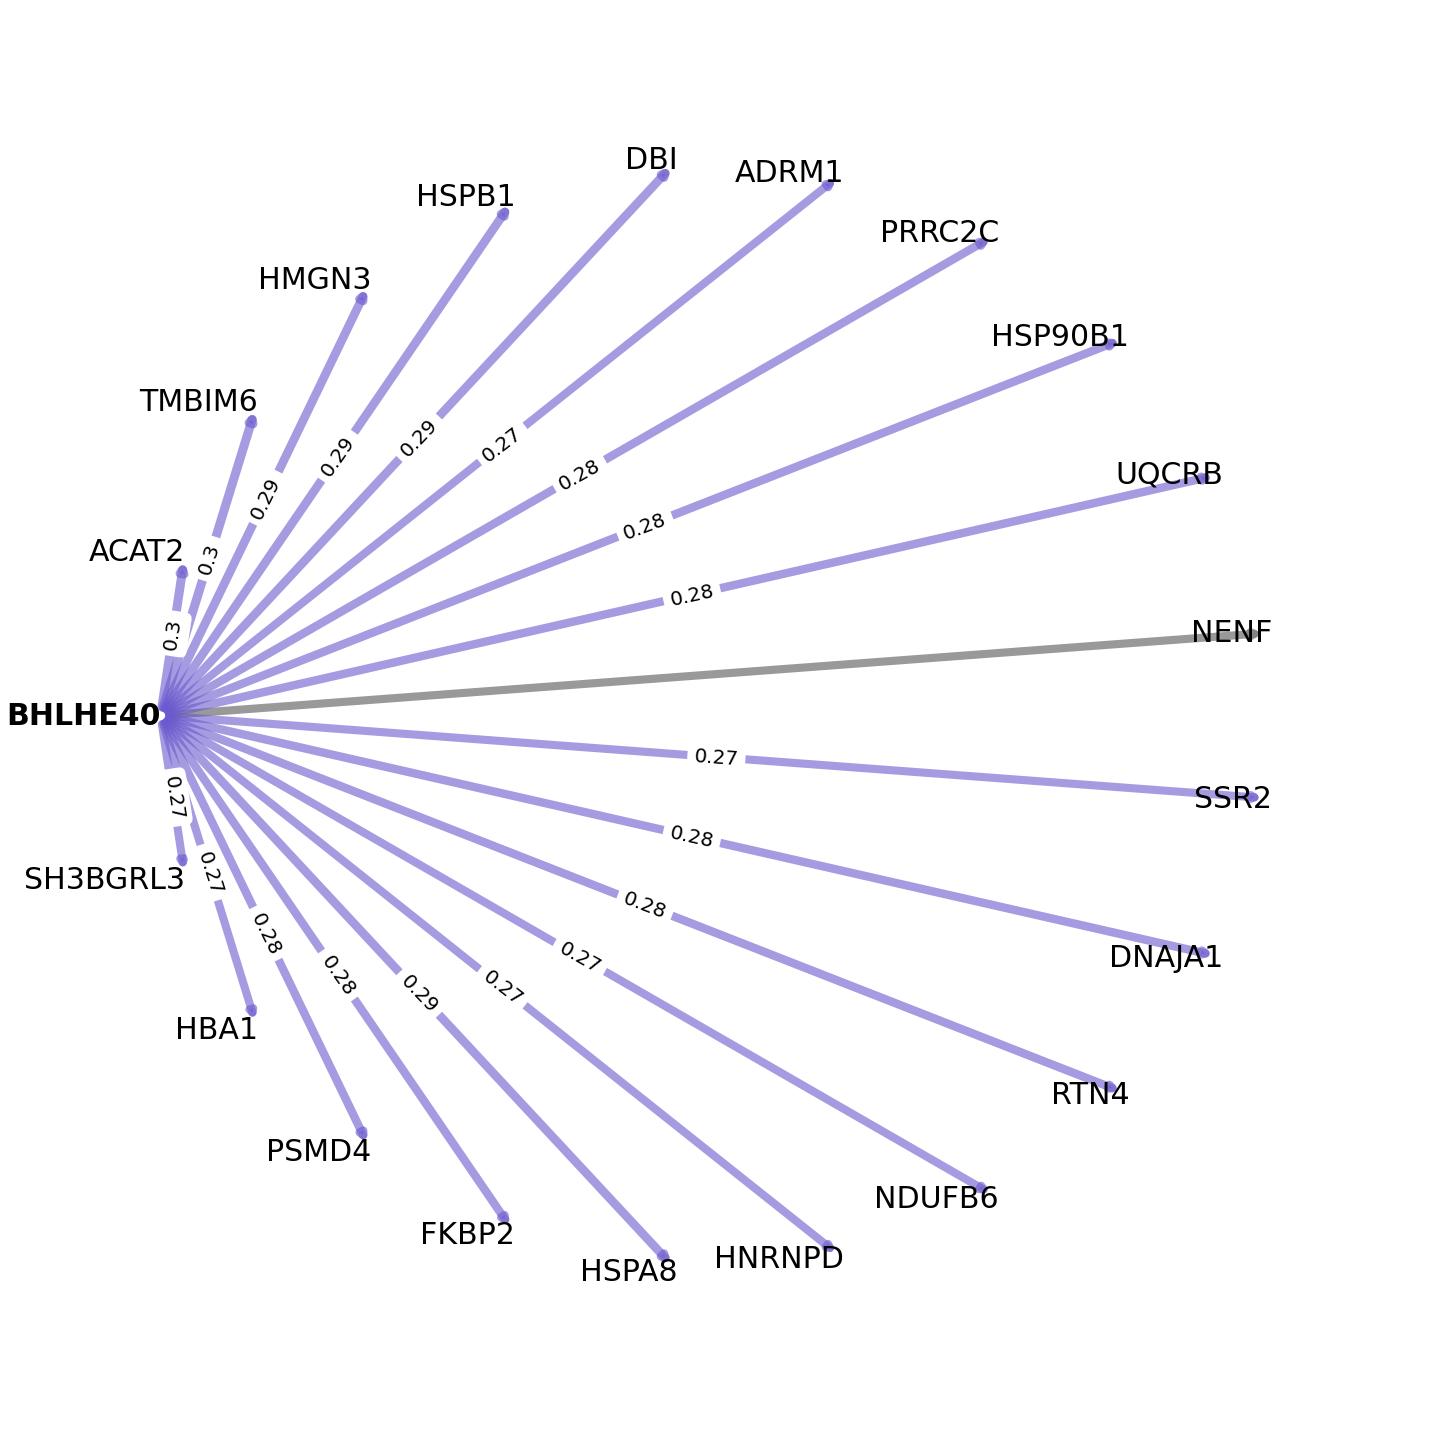

In [ ]:
hits = set(gene_list).intersection(set(df["Target_genes"].values))

G = nx.DiGraph()
edge_list = [
    (TF_name, gene_list[i], round(score_list[i], 2)) for i in range(len(gene_list))
]
G.add_weighted_edges_from(edge_list)

plt.figure(figsize=(20, 20))
edges = list(G.edges)
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if v in hits]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if v not in hits]
pos = nx.shell_layout(G)
width_large = {}
width_small = {}
for i, v in enumerate(edges):
    if v[1] in hits:
        width_large[edges[i]] = G.get_edge_data(v[0], v[1])["weight"] * 30
    else:
        width_small[edges[i]] = max(G.get_edge_data(v[0], v[1])["weight"], 0) * 30
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=width_small.keys(),
    width=list(width_small.values()),
    edge_color="grey",
    alpha=0.8,
)
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=width_large.keys(),
    width=list(width_large.values()),
    alpha=0.6,
    edge_color="slateblue",
)
labels = {}
for i in pos.keys():
    if i == TF_name:
        labels[i] = ""
    else:
        labels[i] = i

labels1 = {}
for i in pos.keys():
    if i != TF_name:
        labels1[i] = ""
    else:
        labels1[i] = i
nx.draw_networkx_labels(
    G, pos, labels, font_size=30, font_family="sans-serif", horizontalalignment="right"
)
nx.draw_networkx_labels(
    G,
    pos,
    labels1,
    font_size=30,
    font_family="sans-serif",
    font_weight="bold",
    horizontalalignment="right",
)

d = nx.get_edge_attributes(G, "weight")
edge_labels = {k: d[k] for k in elarge}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=20)
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

### Step 4.2: Validate against the Reactome database


We perform pathway analysis on the top 100 most influenced genes by checking
against the Reactome database. This replicates the reported pathways found in
the _Difference_ setting in the manuscript for the select TF.


In [ ]:
# Validate with Reactome
df_database = pd.DataFrame(
    data=[
        ["GO_Biological_Process_2021", 6036],
        ["GO_Molecular_Function_2021", 1274],
        ["Reactome_2022", 1818],
    ],
    columns=["dataset", "term"],
)

In [ ]:
databases = ["Reactome_2022"]
m = df_database[df_database["dataset"].isin(databases)][
    "term"
].sum()  # df_database['term'].sum()
p_thresh = 0.05 / ((len(groups.keys()) - 1) * m)

In [ ]:
gene_list = attn_top_gene_dict_100[TF_name + "+ctrl"]

In [ ]:
df_attn = pd.DataFrame()
enr_Reactome = gp.enrichr(
    gene_list=gene_list,
    gene_sets=databases,
    organism="Human",
    outdir="test",
    cutoff=0.5,
)
out = enr_Reactome.results
out["Gene List"] = str(gene_list)
out = out[out["P-value"] < p_thresh]
df_attn = df_attn.append(out, ignore_index=True)

In [ ]:
len(df_attn)

6

In [ ]:
df_attn

Gene_set                                               Term Overlap  \
0  Reactome_2022  AUF1 (hnRNP D0) Binds And Destabilizes mRNA R-...    6/54   
1  Reactome_2022  Regulation Of mRNA Stability By Proteins That ...    7/88   
2  Reactome_2022         Cellular Responses To Stress R-HSA-2262752  16/722   
3  Reactome_2022        Cellular Responses To Stimuli R-HSA-8953897  16/736   
4  Reactome_2022                                S Phase R-HSA-69242   7/161   
5  Reactome_2022  APC/C:Cdc20 Mediated Degradation Of Securin R-...    5/67   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  3.029798e-07          0.000087            0                     0   
1  3.082629e-07          0.000087            0                     0   
2  6.458517e-07          0.000117            0                     0   
3  8.318572e-07          0.000117            0                     0   
4  1.753446e-05          0.001971            0                     0   
5  2.239572e-05          0.002098            0                     0   

   Odds Ratio  Combined Score  \
0   26.119737      392.046796   
1   18.219858      273.157814   
2    5.117280       72.935042   
3    5.014118       70.195667   
4    9.547872      104.562021   
5   16.664147      178.417027   

                                               Genes  \
0                HSPA8;PSMD12;PSMD4;UBC;HNRNPD;HSPB1   
1         HSPA8;PSMD12;PSMD4;EXOSC8;UBC;HNRNPD;HSPB1   
2  HSPA8;PSMD12;HSPA5;CITED2;HBA1;HSP90B1;EEF1A1;...   
3  HSPA8;PSMD12;HSPA5;CITED2;HBA1;HSP90B1;EEF1A1;...   
4               PSMD12;PCNA;PSMD4;UBE2S;MYC;UBC;MCM3   
5                       PSMD12;PSMD4;PTTG1;UBE2S;UBC   

                                           Gene List  
0  ['IL1RN', 'ARHGDIB', 'COL2A1', 'TRAPPC6A', 'PC...  
1  ['IL1RN', 'ARHGDIB', 'COL2A1', 'TRAPPC6A', 'PC...  
2  ['IL1RN', 'ARHGDIB', 'COL2A1', 'TRAPPC6A', 'PC...  
3  ['IL1RN', 'ARHGDIB', 'COL2A1', 'TRAPPC6A', 'PC...  
4  ['IL1RN', 'ARHGDIB', 'COL2A1', 'TRAPPC6A', 'PC...  
5  ['IL1RN', 'ARHGDIB', 'COL2A1', 'TRAPPC6A', 'PC...